# N225 Japan Index trading


### Import dependecies 

In [1]:
import gym
import gym_anytrading
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum

import tensorboard

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import A2C
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

import pandas as pd
from matplotlib import pyplot as plt
from typing import Callable, Dict, List, Optional, Tuple, Type, Union

import torch as th
from torch import nn

from stable_baselines3 import PPO
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold

from finta import TA
from gym_anytrading.envs import StocksEnv
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold

import os

import torch

### Data processing

In [2]:
df = pd.read_csv('data/N225.csv')

In [3]:
df.dropna(inplace=True)

In [4]:
df.dropna(inplace=True)
df['RSI'] = TA.RSI(df)
df['SMA'] = TA.SMA(df,14)
df['ATR'] = TA.ATR(df)
df.dropna(inplace=True)

In [5]:
# Load your financial data into a DataFrame (replace with your own data)
# df = pd.read_csv('your_data.csv')

# Calculate the top 20 technical analysis metrics
sma = TA.SMA(df,20)
ema = TA.EMA(df,20)
rsi = TA.RSI(df,14)
macd = TA.MACD(df)
upper, mid, lower = TA.BBANDS(df)
atr = TA.ATR(df)
stoch = TA.STOCH(df)
cci = TA.CCI(df)
roc = TA.ROC(df)
obv = TA.OBV(df)
adx = TA.ADX(df)
# cmf = TA.CMF(df)
uo = TA.UO(df)
wr = TA.WILLIAMS(df)
# sar = TA.PSAR(df)
# upper, mid, lower = TA.MAE(df['Close'], period=20, percent=0.1)
# conversion_line, base_line, leading_span_A, leading_span_B, lagging_span = TA.ICHIMOKU(df['High'], df['Low'])
adx = TA.ADX(df)
mfi = TA.MFI(df)
# co = TA.CHO(df)
# Combine all the metrics into a single DataFrame
all_metrics_df= pd.DataFrame({
    'SMA': sma,
    'EMA': ema,
    'RSI': rsi,
    'MACD': macd.MACD,
    'MACD_SIGNAL' : macd.SIGNAL,
    # # 'BBANDS_Upper': upper,
    # # 'BBANDS_Mid': mid,
    # # 'BBANDS_Lower': lower,
    'ATR': atr,
    'Stochastic': stoch,
    'CCI': cci,
    'ROC': roc,
    'OBV': obv,
    'ADX': adx,
    'UO': uo,
    'Williams %R': wr,
    'MFI': mfi
})

# Display the DataFrame with all the calculated metrics
# print(all_metrics_df.tail())
df = df.merge(all_metrics_df, right_index=True, left_index=True)

In [6]:
df.dropna(inplace=True)

## Creating custom LSTM model for trading

I create this custom model, becouse I assume, LSTM will work better then normal Neural net. 

 Architecture of this model may change, depending on the final results

In [7]:
class customLSTM(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm=nn.LSTM(input_size,hidden_size,num_layers=2,bidirectional= True)#,batch_first=True)
        self.fully_connected=nn.Sequential(
            nn.Linear(hidden_size*2,4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(4096,2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048,1024),
            nn.BatchNorm1d(1024),
            # nn.ReLU(),
            # nn.Dropout(0.2),
            # nn.Linear(2048,512),
            # nn.BatchNorm1d(512),
            # nn.ReLU(),
            # nn.Dropout(0.2),
            # nn.Linear(512,1024),
            # nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024,output_size),
            nn.ReLU()
        )
    def forward(self,x):
        batch_size=x.shape[0]
        h0=torch.zeros(2*2,self.hidden_size).cuda()
        c0=torch.zeros(2*2,self.hidden_size).cuda()

        lstm_output, cels = self.lstm(x,(h0,c0))
        # print(cels[1].shape)
        flatten_output=torch.flatten(lstm_output,start_dim=1)
        
        output=self.fully_connected(flatten_output)
        
        return output



In [8]:
# from stable_baselines3 import PPO
# from stable_baselines3.common.policies import ActorCriticPolicy


class CustomNetwork(nn.Module):
    """
    :param feature_dim: dimension of the features extracted with the features_extractor (e.g. features from a CNN)
    :param last_layer_dim_pi: (int) number of units for the last layer of the policy network
    :param last_layer_dim_vf: (int) number of units for the last layer of the value network
    """

    def __init__(
        self,
        feature_dim: int,
        last_layer_dim_pi: int = 128,
        last_layer_dim_vf: int = 128,
    ):
        super(CustomNetwork, self).__init__()

        # IMPORTANT:
        # Save output dimensions, used to create the distributions
        self.latent_dim_pi = last_layer_dim_pi
        self.latent_dim_vf = last_layer_dim_vf

        # Policy network
        # self.policy_net = nn.Sequential(
        #     nn.Linear(feature_dim, last_layer_dim_pi), nn.ReLU()
        # )
        
        self.policy_net = customLSTM(feature_dim,512,last_layer_dim_pi)
        # Value network
        self.value_net = nn.Sequential(
            nn.Linear(feature_dim, 512), 
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.Linear(512,256), 
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.Linear(256,256), 
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.Linear(256,128), 
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.Linear(128,last_layer_dim_vf), 
            nn.ReLU()
        )

    def forward(self, features: th.Tensor) -> Tuple[th.Tensor, th.Tensor]:
        """
        :return: (th.Tensor, th.Tensor) latent_policy, latent_value of the specified network.
            If all layers are shared, then ``latent_policy == latent_value``
        """
        return self.policy_net(features), self.value_net(features)

    def forward_actor(self, features: th.Tensor) -> th.Tensor:
        return self.policy_net(features)

    def forward_critic(self, features: th.Tensor) -> th.Tensor:
        return self.value_net(features)


class CustomActorCriticPolicy(ActorCriticPolicy):
    def __init__(
        self,
        observation_space: gym.spaces.Space,
        action_space: gym.spaces.Space,
        lr_schedule: Callable[[float], float],
        net_arch: Optional[List[Union[int, Dict[str, List[int]]]]] = None,
        activation_fn: Type[nn.Module] = nn.Tanh,
        *args,
        **kwargs,
    ):

        super(CustomActorCriticPolicy, self).__init__(
            observation_space,
            action_space,
            lr_schedule,
            net_arch,
            activation_fn,
            # Pass remaining arguments to base class
            *args,
            **kwargs,
        )
        # Disable orthogonal initialization
        self.ortho_init = False

    def _build_mlp_extractor(self) -> None:
        self.mlp_extractor = CustomNetwork(self.features_dim)



## Creating the enviorment and declaring PPO model with custom LSTM net

In [9]:
from enviorment import StocksEnv

In [10]:
env = StocksEnv(df=df,window_size = 14, frame_bound=(3000,5000))

In [11]:
save_path = os.path.join('Training', 'Saved_models_N225')
log_path = os.path.join('Training','Logs')
eval_callback = EvalCallback(env, 
                             eval_freq = 10000, 
                             verbose = 1, 
                             best_model_save_path = save_path)

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [13]:
count_parameters(customLSTM(16*30,1024,128))

56546432

In [14]:

model = PPO(CustomActorCriticPolicy, env, verbose=1,tensorboard_log = log_path)
%time model.learn(50000)#,callback = eval_callback)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to Training\Logs\PPO_8
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.99e+03  |
|    ep_rew_mean     | -2.99e+04 |
| time/              |           |
|    fps             | 195       |
|    iterations      | 1         |
|    time_elapsed    | 10        |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.99e+03     |
|    ep_rew_mean          | -1.61e+04    |
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 2            |
|    time_elapsed         | 38           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 5.092204e-05 |
|    clip_fraction        | 0            |
|    cli

KeyboardInterrupt: 

info {'total_reward': 29237.16995399994, 'total_profit': 0.0016613734675098879, 'position': 1}


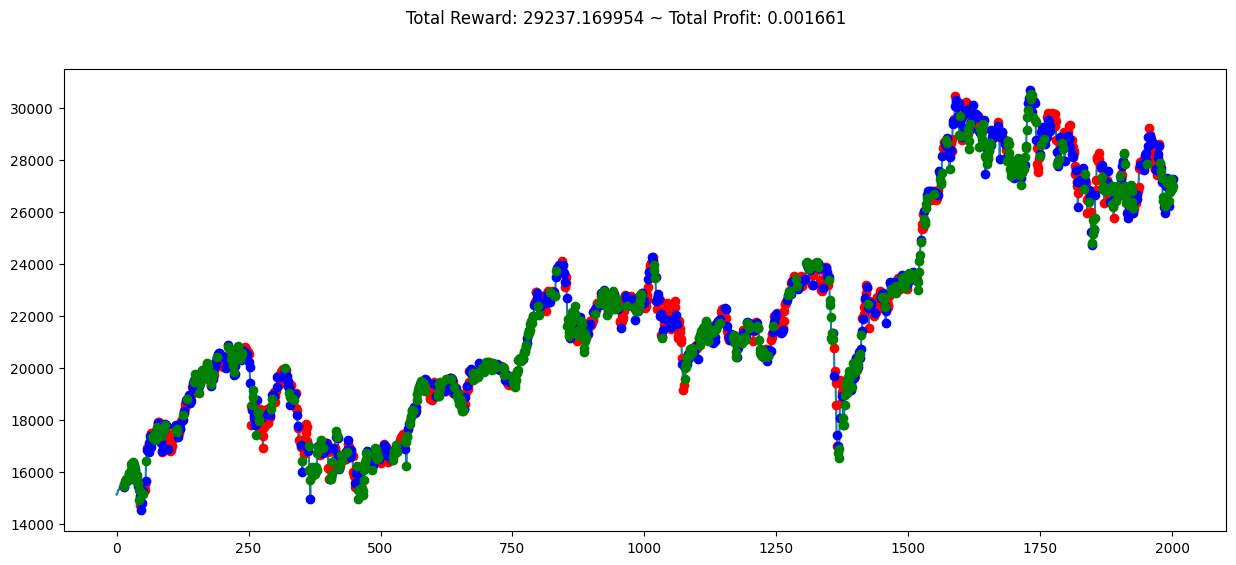

In [15]:
env = StocksEnv(df = df, frame_bound=(3000,5000), window_size = 14)
obs = env.reset()
while True:
    # obs = obs[np.newaxis, ...]
    # print(obs.shape)
    action, _states = model.predict(obs)
    obs,rewards,done,info = env.step(action)
    if done:
        print("info",info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [16]:
env = StocksEnv(df = df, frame_bound=(5014,5300), window_size = 14)
obs = env.reset()
while True:
    # obs = obs[np.newaxis, ...]
    # print(obs.shape)
    action, _states = model.predict(obs)
    obs,rewards,done,info = env.step(action)
    if done:
        print("info",info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

ValueError: zero-size array to reduction operation minimum which has no identity